In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import warnings
import scipy.stats as stats
from tqdm.auto import tqdm
import seaborn as sns
from matplotlib import rc
from sklearn.preprocessing import LabelEncoder
import random
import torch
import torch.nn as nn
import platform
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')
plt.style.use('dark_background')                # 그래프 배경 색상 변경
if platform.system() == 'DARWIN':
    rc('font', family = 'AppleGothic')              # 한글폰트 깨짐현상 제거
else:
    rc('font', family = 'NanumGothic')

plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'retina'  # 그래프 고해상도로 출력

In [2]:
PATH = os.getcwd() + '/data/'
df_brand = pd.read_csv(PATH + 'brand_keyword_cnt.csv')
pd_info = pd.read_csv(PATH + 'product_info.csv')
sales = pd.read_csv(PATH + 'sales.csv')
df_smp = pd.read_csv(PATH + 'sample_submission.csv')
train = pd.read_csv(PATH + 'train.csv')
smp = train.sample(10)

# Dataset Info.
### train.csv
* ID: 실제 판매되고 있는 고유 ID
* 제품: 제품 코드
* 대분류: 제품의 대분류 코드
* 중분류: 제품의 중분류 코드
* 소분류: 제품의 소분류 코드
* 브랜드: 제품의 브랜드 코드
* 2022-01-01 ~ 2023-04-04: 실제 일별 판매량
* `단, 제품이 동일하여도 판매되고 있는 고유 ID 별로 기재한 분류 정보가 상이할 수 있음`
* `즉 고유 ID가 다르다면, 제품이 같더라도 다른 판매 채널`

### sample_submmision.csv
* 2023-04-05 ~ 2023-04-25: 예측한 일별 판매량

### sales.csv - 메타(Meta) 정보
* ID : 실제 판매되고 있는 고유 ID
* 제품 : 제품 코드
* 대분류 : 제품의 대분류 코드
* 중분류 : 제품의 중분류 코드
* 소분류 : 제품의 소분류 코드
* 브랜드 : 제품의 브랜드 코드
* 2022-01-01 ~ 2023-04-04 : 실제 일별 총 판매금액
* `단, 제품이 동일하여도 판매되고 있는 고유 ID 별로 기재한 분류 정보가 상이할 수 있음`
* `즉 고유 ID가 다르다면, 제품이 같더라도 다른 판매 채널`

### brand_keyword_cnt.csv - 메타(Meta) 정보
* 브랜드: 브랜드 코드
* 2022-01-01 ~ 2023-04-04 : 브랜드의 연관키워드 언급량을 **정규화**한 일별 데이터

### product_info.csv [파일] - 메타(Meta) 정보
* 제품 : 제품 코드
* 제품특성 : 제품 특성 데이터(Text)
* `train.csv에 존재하는 모든 제품 코드가 포함되어 있지 않음. 또는 product_info.csv에 존재하는 제품 코드가 train csv에 존재하지 않을 수 있음`


## EDA

In [3]:
def data_melt(df):
    new_df = df.melt(id_vars=df.iloc[:, :6].columns.to_list(), value_vars=df.iloc[:, 6:].columns.to_list())
    new_df = new_df.rename(columns = {'variable' : 'date', 'value' : 'sales'})

    return new_df

In [4]:
def datetime(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.day_of_week
    df['day_name'] = df['date'].dt.day_name()
    df['quarter'] = df['date'].dt.quarter
    return df

In [5]:
df_train = data_melt(train)
df_train = datetime(df_train)
df_train.head(3)

ID                제품             대분류             중분류             소분류  \
0   0  B002-00001-00001  B002-C001-0002  B002-C002-0007  B002-C003-0038   
1   1  B002-00002-00001  B002-C001-0003  B002-C002-0008  B002-C003-0044   
2   2  B002-00002-00002  B002-C001-0003  B002-C002-0008  B002-C003-0044   

          브랜드       date  sales  year  month  day  day_of_week  day_name  \
0  B002-00001 2022-01-01      0  2022      1    1            5  Saturday   
1  B002-00002 2022-01-01      0  2022      1    1            5  Saturday   
2  B002-00002 2022-01-01      0  2022      1    1            5  Saturday   

   quarter  
0        1  
1        1  
2        1

In [6]:
# Label Encoding
train_enc = df_train.copy()
label_encoder = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드', 'day_name']

for col in tqdm(categorical_columns):
    label_encoder.fit(train_enc[col])
    train_enc[col] = label_encoder.transform(train_enc[col])
    if col == 'day_name':
        li = [0, 1, 2, 3, 4, 5, 6]
        for l in li:
            print(l , '->', label_encoder.inverse_transform([l]))

  0%|          | 0/5 [00:00<?, ?it/s]

0 -> ['Friday']
1 -> ['Monday']
2 -> ['Saturday']
3 -> ['Sunday']
4 -> ['Thursday']
5 -> ['Tuesday']
6 -> ['Wednesday']


In [7]:
train_enc.head()

ID                제품  대분류  중분류  소분류  브랜드       date  sales  year  month  \
0   0  B002-00001-00001    1    6   37    0 2022-01-01      0  2022      1   
1   1  B002-00002-00001    2    7   43    1 2022-01-01      0  2022      1   
2   2  B002-00002-00002    2    7   43    1 2022-01-01      0  2022      1   
3   3  B002-00002-00003    2    7   43    1 2022-01-01      0  2022      1   
4   4  B002-00003-00001    0    0    2    2 2022-01-01      0  2022      1   

   day  day_of_week  day_name  quarter  
0    1            5         2        1  
1    1            5         2        1  
2    1            5         2        1  
3    1            5         2        1  
4    1            5         2        1

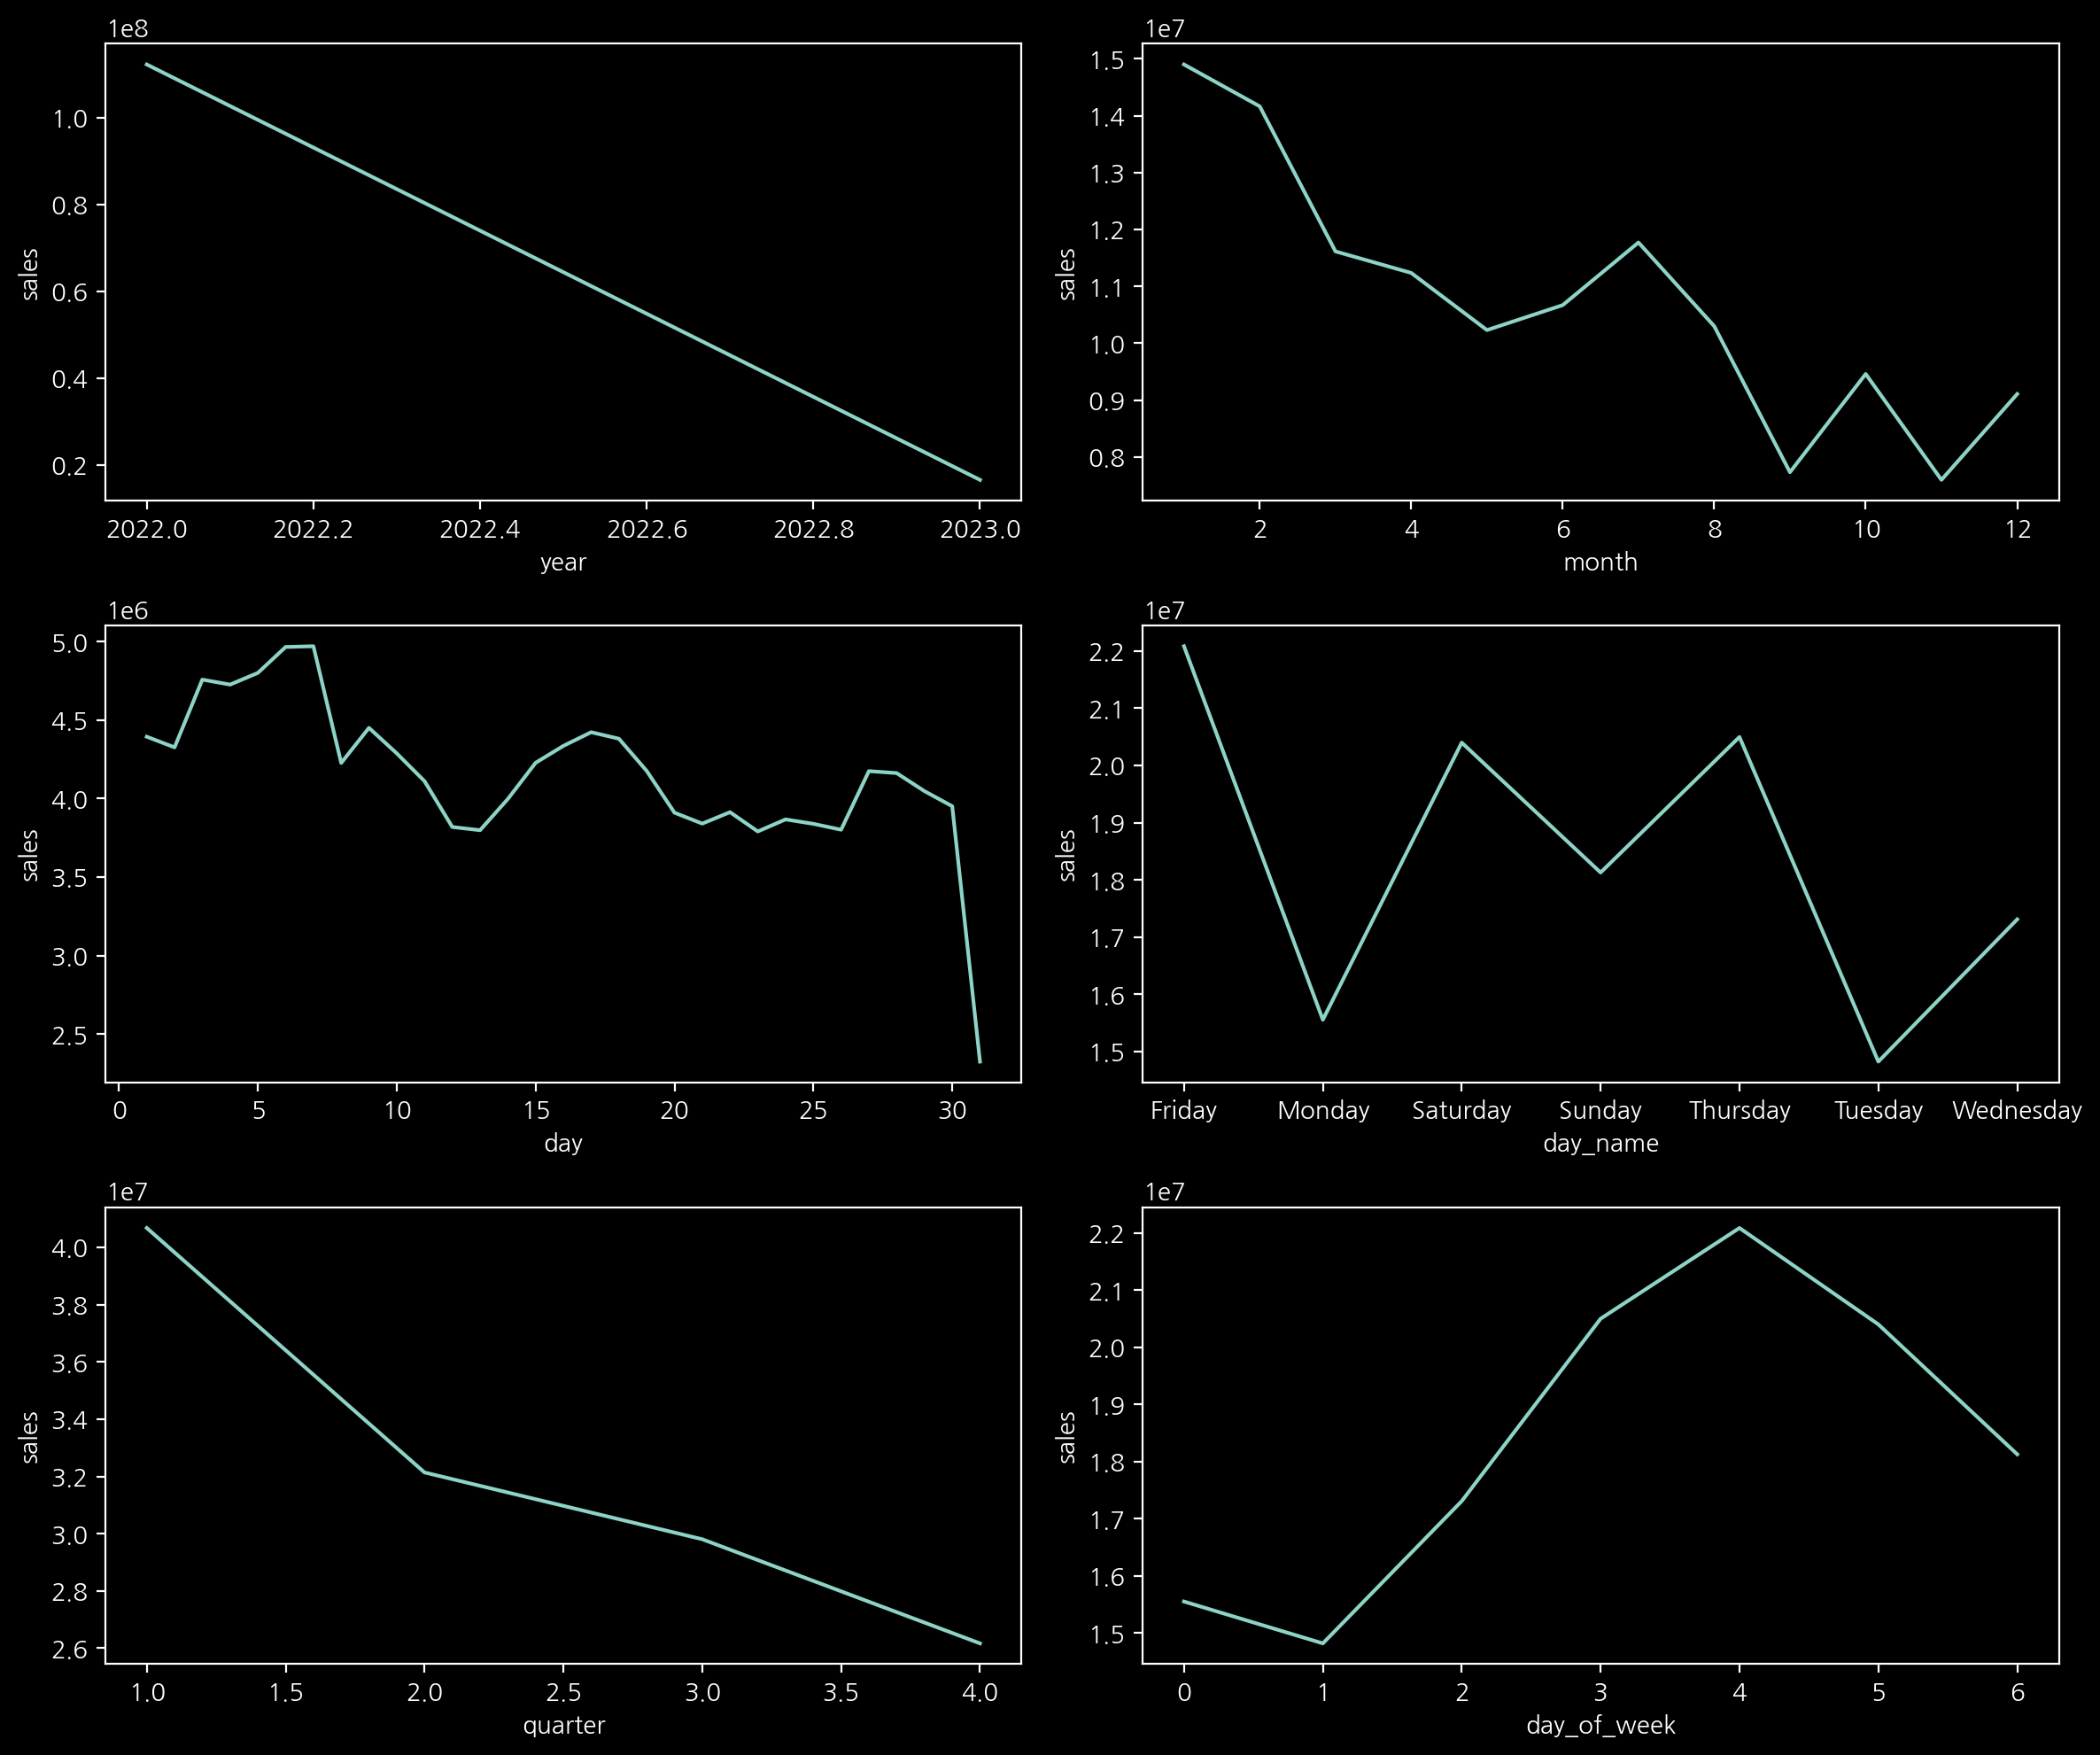

In [8]:
grouping_colunms = ['year', 'month', 'day', 'day_name', 'quarter', 'day_of_week']

fig, axes = plt.subplots(3, 2, figsize = [12, 10])
axes = axes.flatten()

for idx, col in enumerate(grouping_colunms):
    grouped_data = df_train.groupby(col)['sales'].sum()
    grouped_data = pd.DataFrame(grouped_data).reset_index()

    sns.lineplot(data = grouped_data, x = col, y = 'sales', ax = axes[idx])

plt.tight_layout()
plt.show()

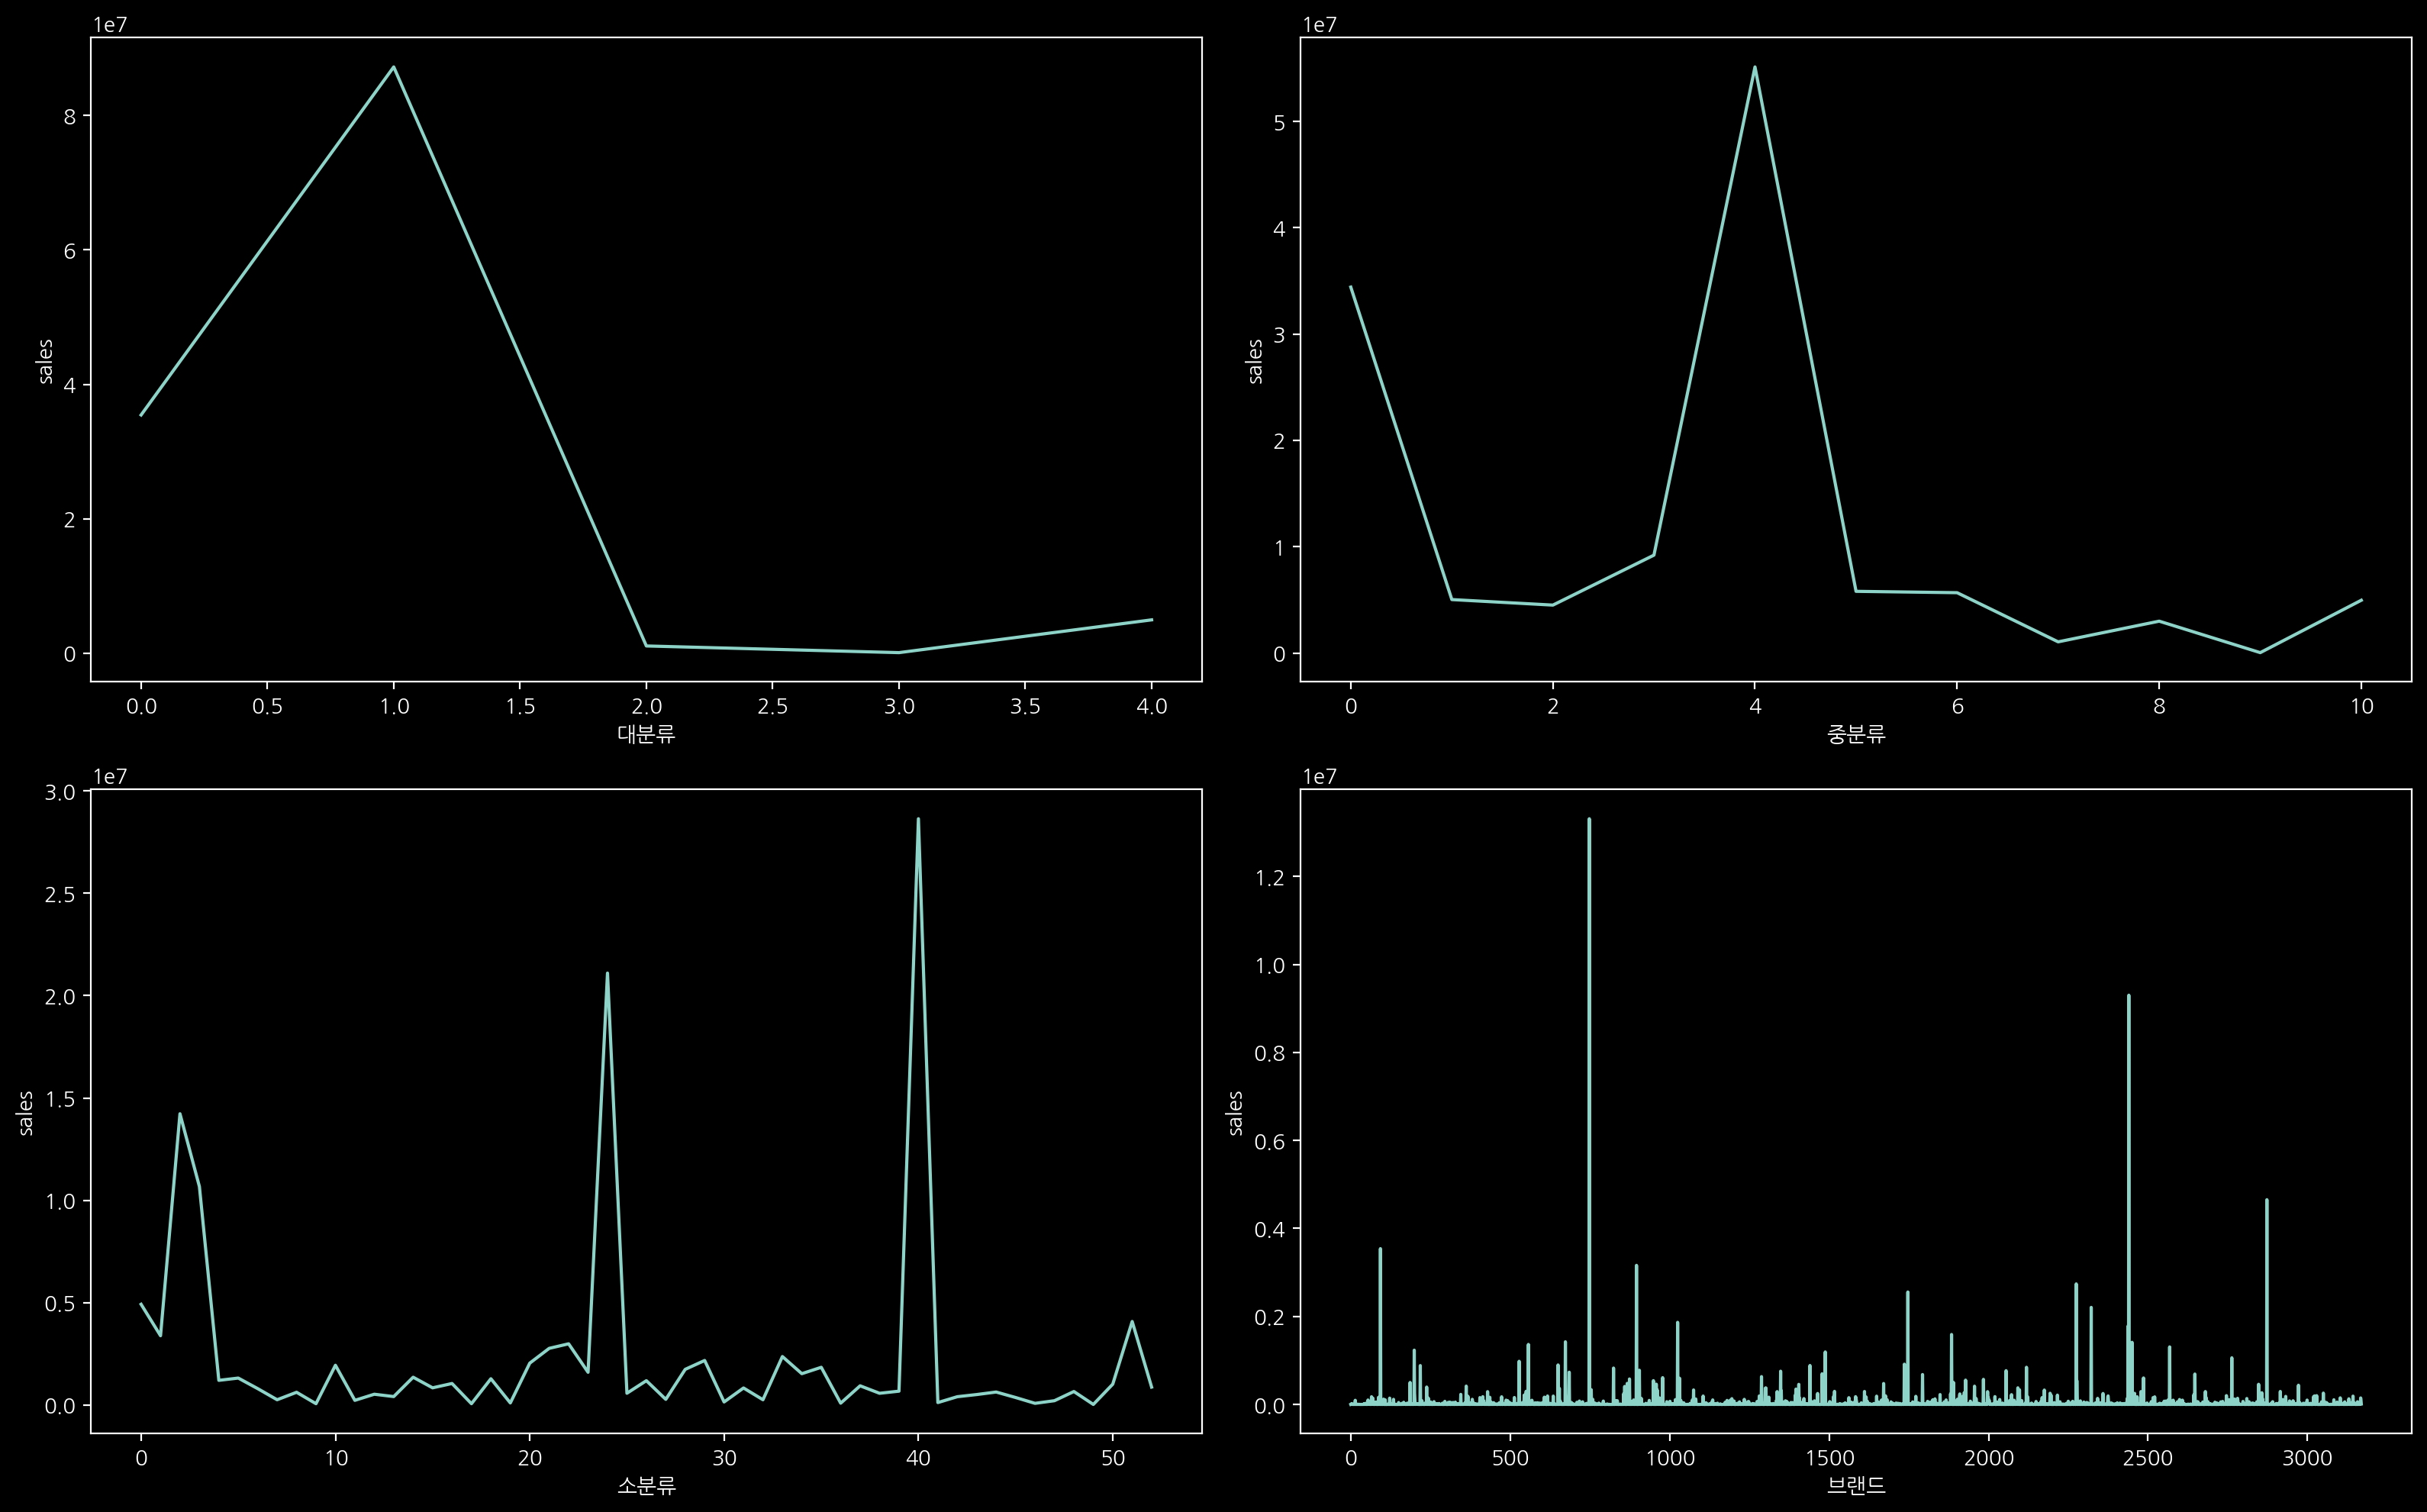

In [9]:
group_col = ['대분류', '중분류', '소분류', '브랜드']

fig, axes = plt.subplots(2, 2, figsize = [16, 10])
axes = axes.flatten()

for idx, col in enumerate(group_col):
    grouped_data = train_enc.groupby(col)['sales'].sum()
    grouped_data = pd.DataFrame(grouped_data).reset_index()

    sns.lineplot(data = grouped_data, x = col, y = 'sales', ax = axes[idx])

plt.tight_layout()
plt.show()

In [10]:
col_name = train_enc.iloc[:, 6:].columns.to_list()
train_enc.groupby('대분류', as_index = False)['sales'].sum()


대분류     sales
0    0  35441662
1    1  87218401
2    2   1078827
3    3     85411
4    4   4961560

In [11]:
print('train_enc과 df_brand의 브랜드 갯수읟 동일 여부 :', train_enc.브랜드.nunique() == df_brand.브랜드.nunique())
print('브랜드 개수 :',df_brand.브랜드.nunique())

train_enc과 df_brand의 브랜드 갯수읟 동일 여부 : True
브랜드 개수 : 3170


## Brand 인지도 정규화 데이터 EDA

In [225]:
df_keyword = df_brand.iloc[:, 1:]
display(df_keyword.head(3))

2022-01-01  2022-01-02  2022-01-03  2022-01-04  2022-01-05  2022-01-06  \
0     0.84131     0.91383     1.45053     2.42239     1.87119     1.58108   
1    12.64868    20.27850    15.33217    12.75021    13.56251    13.70757   
2     0.33362     0.43516     0.36263     0.17406     0.21758     0.46417   

   2022-01-07  2022-01-08  2022-01-09  2022-01-10  ...  2023-03-26  \
0     1.23295     1.17493     1.14592     1.23295  ...     0.31911   
1    11.93791    15.56425    14.08471    16.23150  ...    10.26979   
2     0.42065     0.29010     0.37713     0.75427  ...     0.53669   

   2023-03-27  2023-03-28  2023-03-29  2023-03-30  2023-03-31  2023-04-01  \
0     0.39164     0.37713     0.49318     0.07252     0.29010     0.31911   
1    11.96692    10.64693    10.41485    10.48738     9.48651     9.28343   
2     0.69625     0.44966     0.39164     1.02988     0.49318     0.91383   

   2023-04-02  2023-04-03  2023-04-04  
0     0.23208     0.33362     0.44966  
1    10.42935    11.15462    11.38671  
2     0.79779     1.01537     0.88482  

[3 rows x 459 columns]

In [95]:
na_list = []
for i in range(df_keyword.shape[0]):
    sum_ = sum(df_keyword.iloc[i, :].isna())
    if sum_ is not 0:
        na_list.append(df_brand.iloc[i, :].브랜드)

na_idx = []
for brand in na_list:
   na_idx.append(df_brand[df_brand.브랜드 == brand].index[0])

brand_new = df_brand.drop(na_idx, axis = 0)
brand_new = brand_new.reset_index(drop = True)
brand_new.head(3)

브랜드  2022-01-01  2022-01-02  2022-01-03  2022-01-04  2022-01-05  \
0  B002-00001     0.84131     0.91383     1.45053     2.42239     1.87119   
1  B002-00002    12.64868    20.27850    15.33217    12.75021    13.56251   
2  B002-00003     0.33362     0.43516     0.36263     0.17406     0.21758   

   2022-01-06  2022-01-07  2022-01-08  2022-01-09  ...  2023-03-26  \
0     1.58108     1.23295     1.17493     1.14592  ...     0.31911   
1    13.70757    11.93791    15.56425    14.08471  ...    10.26979   
2     0.46417     0.42065     0.29010     0.37713  ...     0.53669   

   2023-03-27  2023-03-28  2023-03-29  2023-03-30  2023-03-31  2023-04-01  \
0     0.39164     0.37713     0.49318     0.07252     0.29010     0.31911   
1    11.96692    10.64693    10.41485    10.48738     9.48651     9.28343   
2     0.69625     0.44966     0.39164     1.02988     0.49318     0.91383   

   2023-04-02  2023-04-03  2023-04-04  
0     0.23208     0.33362     0.44966  
1    10.42935    11.15462    11.38671  
2     0.79779     1.01537     0.88482  

[3 rows x 460 columns]

In [96]:
keyword_num = brand_new.iloc[:, 1:]
arr_keyword = np.array(keyword_num)
brand_mean_li = []  # 각 브랜드 별 평균값을 저장
day_mean_li = []    # 각 일자 별 평균값을 저장
for i in range(arr_keyword.shape[0]):
    brand_mean_li.append(np.mean(arr_keyword[i][:]))

for i in range(arr_keyword.shape[1]):
    day_mean_li.append(np.mean(arr_keyword[:, i]))

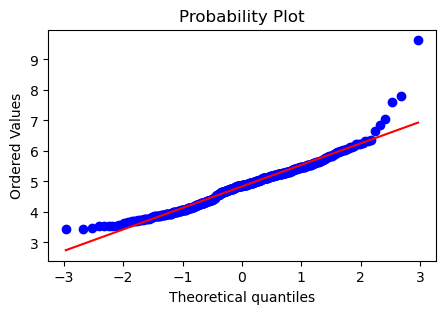

In [97]:
fig = plt.figure(figsize = [5, 3])
stats.probplot(np.array(day_mean_li), dist = stats.norm, plot = plt)
plt.show()

In [135]:
brand_list = list(brand_new.브랜드.values)
for i in range(df_train.shape[0]):
    if df_train.loc[i, '브랜드'] in brand_list:
        pass
    else:
        df_train.drop(i, axis = 0, inplace = True)

In [146]:
sales_by_brand = df_train.iloc[:, 5:]
sales_by_brand = sales_by_brand.groupby('브랜드', as_index = False).sum()

In [150]:
print(sales_by_brand.shape)
print(brand_new.shape)

(3135, 460)
(3135, 460)


In [160]:
display(sales_by_brand.head(3))
brand_new.head(3)

브랜드  2022-01-01  2022-01-02  2022-01-03  2022-01-04  2022-01-05  \
0  B002-00001           0           0           0           0           0   
1  B002-00002           0           0           0           0           0   
2  B002-00003           0           0           0          22          37   

   2022-01-06  2022-01-07  2022-01-08  2022-01-09  ...  2023-03-26  \
0           0           0           0           0  ...           0   
1           0           0           0           0  ...           0   
2          39          30          28          23  ...           0   

   2023-03-27  2023-03-28  2023-03-29  2023-03-30  2023-03-31  2023-04-01  \
0           0           0           0           0           0           0   
1           0           0           1           3           2           0   
2           0           0           0           0           0           0   

   2023-04-02  2023-04-03  2023-04-04  
0           0           0           0  
1           0           2           0  
2           0           0          11  

[3 rows x 460 columns]

브랜드  2022-01-01  2022-01-02  2022-01-03  2022-01-04  2022-01-05  \
0  B002-00001     0.84131     0.91383     1.45053     2.42239     1.87119   
1  B002-00002    12.64868    20.27850    15.33217    12.75021    13.56251   
2  B002-00003     0.33362     0.43516     0.36263     0.17406     0.21758   

   2022-01-06  2022-01-07  2022-01-08  2022-01-09  ...  2023-03-26  \
0     1.58108     1.23295     1.17493     1.14592  ...     0.31911   
1    13.70757    11.93791    15.56425    14.08471  ...    10.26979   
2     0.46417     0.42065     0.29010     0.37713  ...     0.53669   

   2023-03-27  2023-03-28  2023-03-29  2023-03-30  2023-03-31  2023-04-01  \
0     0.39164     0.37713     0.49318     0.07252     0.29010     0.31911   
1    11.96692    10.64693    10.41485    10.48738     9.48651     9.28343   
2     0.69625     0.44966     0.39164     1.02988     0.49318     0.91383   

   2023-04-02  2023-04-03  2023-04-04  
0     0.23208     0.33362     0.44966  
1    10.42935    11.15462    11.38671  
2     0.79779     1.01537     0.88482  

[3 rows x 460 columns]

In [178]:
pd.merge(sales_by_brand, brand_new, on = '브랜드').iloc[:, 1:460]
pd.merge(sales_by_brand, brand_new, on = '브랜드').iloc[:, 460:]

2022-01-01_y  2022-01-02_y  2022-01-03_y  2022-01-04_y  2022-01-05_y  \
0          0.84131       0.91383      1.450530      2.422390      1.871190   
1         12.64868      20.27850     15.332170     12.750210     13.562510   
2          0.33362       0.43516      0.362630      0.174060      0.217580   
3          1.07339       1.71163      2.016240      1.914700      1.987230   
4          0.00000       0.00000      0.188558      0.246574      0.246574   
...            ...           ...           ...           ...           ...   
3130       2.32085       2.98810      3.611830      4.061500      3.669850   
3131       0.14505       0.00000      0.087030      0.072520      0.087030   
3132       0.00000       0.00000      0.000000      0.000000      0.000000   
3133       0.14505       0.00000      0.116040      0.072520      0.116040   
3134       4.55468       5.54105      6.150270      6.396860      7.006090   

      2022-01-06_y  2022-01-07_y  2022-01-08_y  2022-01-09_y  2022-01-10_y  \
0         1.581080      1.232950      1.174930      1.145920      1.232950   
1        13.707570     11.937910     15.564250     14.084710     16.231500   
2         0.464170      0.420650      0.290100      0.377130      0.754270   
3         2.146790      1.682620      1.378000      1.421520      2.610960   
4         0.246574      0.377139      0.087012      0.261084      0.333609   
...            ...           ...           ...           ...           ...   
3130      3.771390      3.031620      2.988100      3.133150     11.285170   
3131      0.101530      0.072520      0.130540      0.116040      0.072520   
3132      0.101530      0.000000      0.000000      0.000000      0.000000   
3133      0.275600      0.217580      0.116040      0.101530      0.246590   
3134      6.657960      5.802140      5.483020      6.034230      7.136640   

      ...  2023-03-26_y  2023-03-27_y  2023-03-28_y  2023-03-29_y  \
0     ...      0.319110      0.391640      0.377130       0.49318   
1     ...     10.269790     11.966920     10.646930      10.41485   
2     ...      0.536690      0.696250      0.449660       0.39164   
3     ...      2.219320      2.509420      2.872060       2.37888   
4     ...      0.072526      0.290103      0.087012       0.00000   
...   ...           ...           ...           ...           ...   
3130  ...      2.422390      2.422390      2.756010       2.32085   
3131  ...      0.000000      0.072520      0.000000       0.10153   
3132  ...      0.000000      0.000000      0.000000       0.00000   
3133  ...      0.101530      0.087030      0.145050       0.17406   
3134  ...      5.105880      6.672460      6.440380       5.90368   

      2023-03-30_y  2023-03-31_y  2023-04-01_y  2023-04-02_y  2023-04-03_y  \
0         0.072520       0.29010       0.31911      0.232080      0.333620   
1        10.487380       9.48651       9.28343     10.429350     11.154620   
2         1.029880       0.49318       0.91383      0.797790      1.015370   
3         2.030750       1.53756       1.34899      1.261960      2.320850   
4         0.130542       0.00000       0.00000      0.072526      0.217577   
...            ...           ...           ...           ...           ...   
3130      2.088770       1.98723       1.07339      1.929210      2.509420   
3131      0.101530       0.00000       0.00000      0.000000      0.000000   
3132      0.000000       0.00000       0.00000      0.000000      0.072520   
3133      0.188560       0.11604       0.11604      0.087030      0.174060   
3134      4.931820       5.51203       3.52480      4.032490      5.889170   

      2023-04-04_y  
0          0.44966  
1         11.38671  
2          0.88482  
3          2.30635  
4          0.00000  
...            ...  
3130       1.78416  
3131       0.00000  
3132       0.07252  
3133       0.10153  
3134       5.07687  

[3135 rows x 459 columns]

In [8]:
np.random.seed(0)

brand_smp = np.array(df_brand.iloc[0, 1:]).astype(float)
# stats.probplot(brand_smp, dist = stats.norm, plot = plt)
# plt.show()
smp = pd.DataFrame(df_brand.iloc[0, 1:])
smp = smp.transpose()
smp

2022-01-01 2022-01-02 2022-01-03 2022-01-04 2022-01-05 2022-01-06  \
0    0.84131    0.91383    1.45053    2.42239    1.87119    1.58108   

  2022-01-07 2022-01-08 2022-01-09 2022-01-10  ... 2023-03-26 2023-03-27  \
0    1.23295    1.17493    1.14592    1.23295  ...    0.31911    0.39164   

  2023-03-28 2023-03-29 2023-03-30 2023-03-31 2023-04-01 2023-04-02  \
0    0.37713    0.49318    0.07252     0.2901    0.31911    0.23208   

  2023-04-03 2023-04-04  
0    0.33362    0.44966  

[1 rows x 459 columns]

<Axes: >

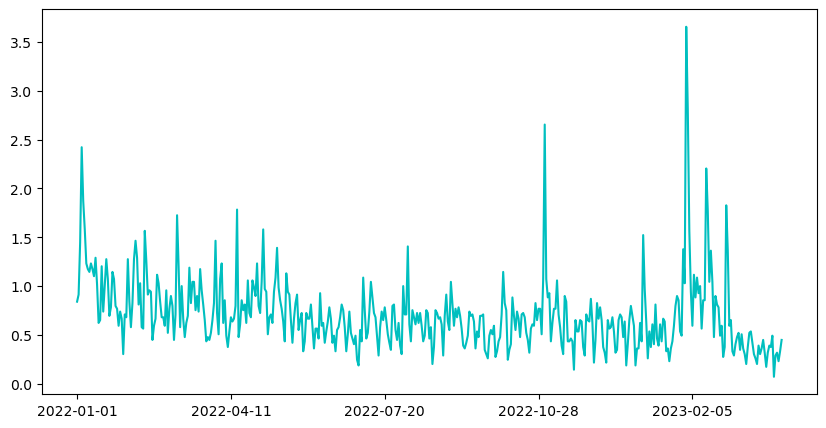

In [9]:
plt.figure(figsize = (10,5))
df_brand.drop(columns = '브랜드').transpose().iloc[:, 0].plot(c = 'c')

## Product Info WordCloud

In [74]:
train_id = list(df_train.제품)
product_id = list(pd_info.제품)

In [75]:
cnt = 0
no_pd = []
yes_pd = []
for t in train_id:
    if t in product_id:
        cnt += 1
        yes_pd.append(t)
    else:
        no_pd.append(t)
print(cnt)

10481


In [76]:
cnt = 0
no = []
yes = []
for p in product_id:
    if p in train_id:
        cnt += 1
        yes.append(p)
    else:
        no.append(p)
print(cnt)
print(no[0])

10442
B002-00245-00007


In [77]:
cnt = 0
for y in yes:
    if y in yes_pd:
        cnt += 1
    
    else:
        pass

print(len(yes) == cnt)

True


In [78]:
dic = {}
dic_info = {}

for i in range(df_train.shape[0]):
    dic[i] = df_train.loc[i, '제품']
print(len(dic.keys()))

for i in range(pd_info.shape[0]):
    dic_info[i] = pd_info.loc[i, '제품']
print(len(dic_info.keys()))

15890
12778


In [79]:
dic_copy = dic.copy()
info_copy = dic_info.copy()
dic_yes = {}

for k, v in dic_copy.items():
    if v in yes:
        cnt += 1
        dic_yes[k] = v
    else:
        pass

for k, v in info_copy.items():
    if v not in yes:
        del dic_info[k]
    else:
        pass

In [80]:
id_list = list(dic_yes.keys())
info_train = df_train.loc[id_list, :]

info_id = list(dic_info.keys())
info_df = pd_info.loc[info_id, :]

In [81]:
df_merge = pd.merge(info_train.iloc[:, 0:6], info_df)
df_merge.head(3)

ID                제품             대분류             중분류             소분류  \
0   0  B002-00001-00001  B002-C001-0002  B002-C002-0007  B002-C003-0038   
1  12  B002-00003-00009  B002-C001-0001  B002-C002-0001  B002-C003-0003   
2  16  B002-00005-00001  B002-C001-0002  B002-C002-0006  B002-C003-0032   

          브랜드                                               제품특성  
0  B002-00001  헤어타입:모든 모발용 제품형태:스프레이형 주요제품특징:머릿결개선 주요제품특징:흡수력...  
1  B002-00003  생균:100억 CFU 1일 총 섭취량:1캡슐 제품용량:1개월분 제품타입:캡슐 섭취횟...  
2  B002-00005  피부타입:모든피부용 향계열:과일향 주요제품특징:향 주요제품특징:촉촉함(수분공급) 용...

In [15]:
major_class = list(df_merge.대분류.value_counts().keys())
major_class # 대분류 코드 리스트

['B002-C001-0002',
 'B002-C001-0001',
 'B002-C001-0005',
 'B002-C001-0003',
 'B002-C001-0004']

In [37]:
major_1 = df_merge[df_merge.대분류 == major_class[0]]
major_2 = df_merge[df_merge.대분류 == major_class[1]]
major_3 = df_merge[df_merge.대분류 == major_class[2]]
major_4 = df_merge[df_merge.대분류 == major_class[3]]
major_5 = df_merge[df_merge.대분류 == major_class[4]]

major_list = [major_1, major_2, major_3, major_4, major_5]

In [36]:
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('jhgan/ko-sroberta-multitask')

In [38]:
def preprocessing(major_class):
    major_class['제품특성'] = major_class['제품특성'] \
        .replace(r'[^가-힣 ]', ' ', regex=True) \
        .replace("'", '') \
        .replace(r'\s+', ' ', regex=True) \
        .str.strip() \
        .str[:255]
    
    return major_class['제품특성']

def remove_stopwords(text):
    tokens = text.split(' ')
    stops = '특징'

    meaningful_words = [w for w in tokens if stops not in w]
    return ' '.join(meaningful_words)

for major in major_list:
    major['제품특성'] = preprocessing(major).apply(remove_stopwords)

In [ ]:
info = pd.DataFrame(df_merge.제품특성)
info.head(3)

In [89]:
info['제품특성'] = preprocessing(info).apply(remove_stopwords)
info_corpus = info['제품특성'].values.tolist()
len(info_corpus)

10481

In [90]:
info_embeddings = model.encode(info_corpus)

In [46]:
corpuses = [major['제품특성'].values.tolist() for major in major_list]
len(corpuses)


5

In [47]:
embeddings = []
for corpus in corpuses:
    embeddings.append(model.encode(corpus))

embeddings[0]

array([[-0.09435715,  0.11119701, -0.0817894 , ..., -0.09455094,
         0.02664886,  0.23769051],
       [-0.17400339, -0.42415226, -0.48827496, ...,  0.2890863 ,
         0.6123826 ,  0.14351831],
       [-0.38109103, -0.02383031, -0.39400738, ...,  0.37905264,
         0.58046705, -0.6088942 ],
       ...,
       [-0.27064025, -0.23144609, -0.38095573, ...,  0.18317491,
        -0.01841969, -0.0904296 ],
       [-0.04407345, -0.02161439, -0.07202958, ...,  0.32397604,
         0.2714205 , -0.23029247],
       [ 0.205234  , -0.09115069, -0.67466986, ...,  0.23071016,
        -0.08201838, -0.5348482 ]], dtype=float32)

In [98]:
def clustering(embeddings, corpus):
    num_clusters = 8
    clustering_model = KMeans(n_clusters=num_clusters)
    clustering_model.fit(embeddings)
    cluster_assignment = clustering_model.labels_

    clustered_sentences = [[] for i in range(num_clusters)]
    for sentence_id, cluster_id in enumerate(cluster_assignment):
        clustered_sentences[cluster_id].append(corpus[sentence_id])

    for i, cluster in enumerate(clustered_sentences):
        print('Cluster %d (%d)' % (i+1, len(cluster)))
        print(cluster)
        print('')

    return clustered_sentences

In [58]:
clustering(embeddings[1], corpuses[1])

Cluster 1 (323)
['홍삼농축액 함량 고형분 함량 포장형태 스틱형 일 총 섭취량 포 제품용량 개월분 섭취횟수 하루 한 번 섭취방법 바로 음용 섭취대상 유아 청소년 홍삼액 종류 농축액 제품유형 일반식품 개 개입', '홍삼농축액 함량 고형분 함량 일 총 섭취량 포 제품용량 개인별 다름 섭취횟수 하루 한 번 섭취방법 씹어서 섭취대상 성인남녀 개 제품용량 개인별 다름 섭취방법 바로 음용 섭취대상 성인남녀 개 일 총 섭취량 스푼 제품용량 일분 섭취횟수 하루 세 번 섭취방법 물에 섞어서 섭취대상 성인남녀 홍삼액 종류 농축액 제품유형 건강기능식품 주요 기능성 식약처인증 면역력 영양소 원료명 식약처고시 해당 없음 개 일 총 섭취량 스푼 제품용량 일분 섭취횟수 하루 세 번 섭취방', '홍삼농축액 함량고형분 함량 일 총 섭취량제품용량섭취횟수섭취방법섭취대상진세노사이드 일 총 섭취량 정 제품용량 일분 섭취횟수 하루 한 번 섭취방법 씹어서 섭취대상 성인남녀 개 홍삼농축액 함량고형분 함량 일 총 섭취량제품용량섭취횟수섭취방법섭취대상진세노사이드 일 총 섭취량섭취횟수섭취방법섭취대상 포 일 총 섭취량섭취횟수섭취방법섭취대상 개 홍삼농축액 함량고형분 함량 일 총 섭취량제품용량섭취횟수섭취방법섭취대상진세노사이드 섭취횟수섭취방법섭취대상 하루 한 번 홍삼농축액', '제품용량 개월분 정', '포장형태 스틱형 포', '홍삼농축액 함량고형분 함량진세노사이드 일 총 섭취량제품용량섭취횟수섭취방법섭취대상제품유형식품품질인증주요 기능성 식약처인증 영양소 원료명 식약처고시 홍삼농축액 함량고형분 함량진세노사이드 일 총 섭취량제품용량섭취횟수섭취방법섭취대상제품유형식품품질인증주요 기능성 식약처인증 영양소 원료명 식약처고시 섭취방법 바로 음용 홍삼액 종류 제품유형 추출액 일반식품 홍삼농축액 함량고형분 함량진세노사이드 일 총 섭취량제품용량섭취횟수섭취방법섭취대상제품유형식품품질인증주요 기능성 ', '홍삼농축액 함량 고형분 함량 일 총 섭취량 포 제품용량 일분 섭취횟수 하루 한 번 섭취방법 바로 음용 섭취대상 성인남녀 제품

In [99]:
clusters = clustering(info_embeddings, info_corpus)

Cluster 1 (701)
['기능기능용량 충치예방 형태기능기능용량 일반용기형 개', '종류 일반형 기능 프라그제거 기능 충치예방 기능 심미효과 기능 구취제거 기능 구강청결 무불소 무합성방부제 무향 개', '기능 구강청결 정', '종류 고체형 기능 구강청결 무트리클로산 무동물성원료 무사카린 무광물성오일 개 종류 고체형 기능 프라그제거 기능 충치예방 기능 구취제거 기능 미백 기능 구강청결 기능 치석형성억제 기능 치주질환예방 무화학계면활성제 무 개 종류 고체형 기능 프라그제거 기능 충치예방 기능 구취제거 기능 미백 기능 치주질환예방 무트리클로산 무동물성원료 무사카린 무광물성오일 무 개 기능 구강청결 정', '종류 고체형 기능 구강청결 무트리클로산 무동물성원료 무사카린 무광물성오일 개 종류 고체형 기능 프라그제거 기능 충치예방 기능 구취제거 기능 미백 기능 구강청결 기능 치석형성억제 기능 치주질환예방 무화학계면활성제 무 개 종류 고체형 기능 프라그제거 기능 충치예방 기능 구취제거 기능 미백 기능 치주질환예방 무트리클로산 무동물성원료 무사카린 무광물성오일 무 개 기능 구강청결 정', '칫솔종류 일반 칫솔 칫솔모타입 미세모 극세모 재질 플라스틱 칫솔헤드크기 일반형 항균 은첨가 개', '종류 일반형 기능 충치예방 기능 구취제거 기능 구강청결 개', '종류 치간칫솔 자형 교정용 재질 플라스틱 향 유무 무향 총 수량 개 개 종류 치간칫솔 자형 교정용 재질 플라스틱 재질 기타 향 유무 무향 와이어굵기 총 수량 개 개 개', '종류 일반형 기능 프라그제거 기능 충치예방 기능 심미효과 기능 구취제거 기능 미백 기능 잇몸질환예방 기능 구강청결 기능 치은염예방 기능 치주염예방 기능 세균제거 기능 치주질환예방 개', '기능기능 구취제거', '종류 일반형 기능 프라그제거 기능 심미효과 기능 구취제거 기능 미백 기능 잇몸질환예방 기능 구강청결 기능 치은염예방 기능 치주염예방 기능 치주질환예방 개 종류 일반형 기능 프라그제거 기능 충치예방 기능 심미효과 기능 구취제거 기능 미백 기능 구강

개 11583
용량 7871
기능 5124
수분공급 4389
구성 4380
무첨 4021


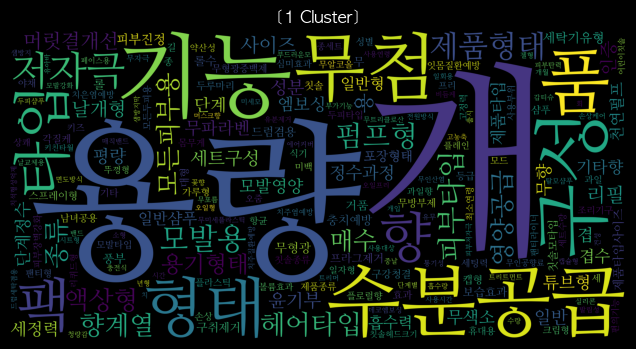

영양소 7966
원료명 7810
식약처고시 7709
비타민 4582
일 3459
섭취방법 3232


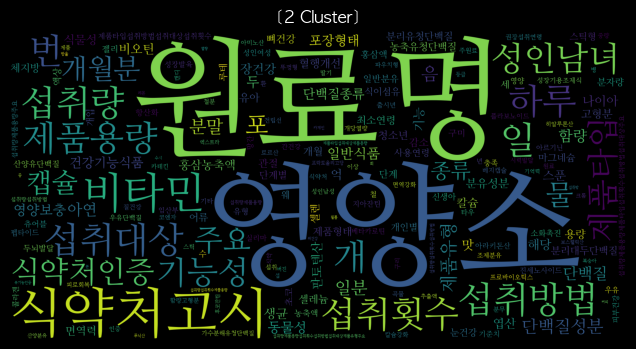

개 945
최소연령 881
유발성분 699
종류 671
기타 669
알레르기 628


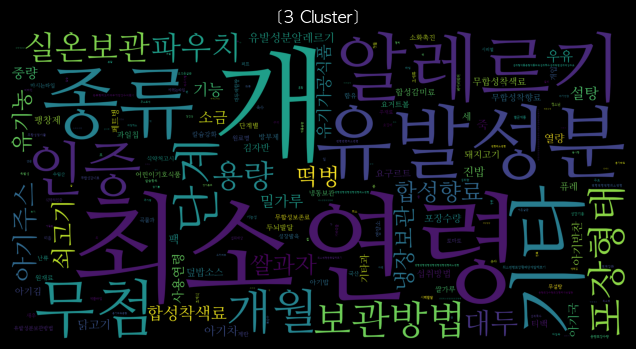

용량 195
형태 170
젖병 142
개 120
무첨 116
소독 116


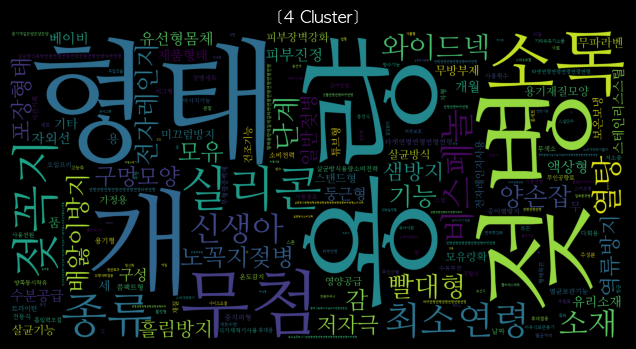

무첨 538
저자극 156
피부진정 156
자외선차단지수 154
개 154
포장형태 148


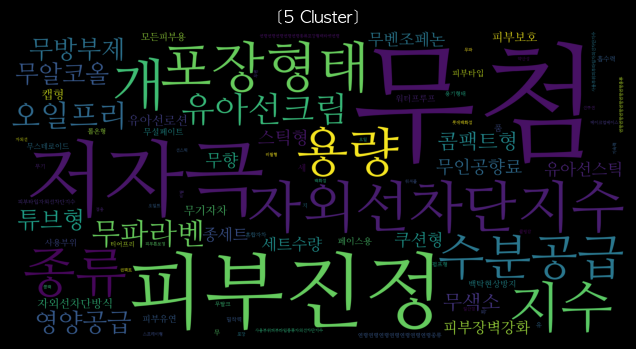

In [71]:
from konlpy.tag import Komoran, Okt, Kkma, Hannanum
from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud
from matplotlib import rc
%matplotlib inline
rc('font', family = 'AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

cnt = 1
for major in major_list:
    fig = plt.figure(figsize=(8, 4), facecolor= 'black')

    extractor = Hannanum()

    nouns = []

    for f in major['제품특성'].values.tolist():
        nouns.extend(extractor.nouns(f))

    count = Counter(nouns)
    words = dict(count.most_common())

    for i, (word, count) in enumerate(words.items()):
        if i > 5:
            break
        print(word, count)
        
    wc = WordCloud(
        font_path='/Users/a1r/Library/Fonts/NanumMyeongjo.ttf',
        width=2000,
        height=1000
    ).generate_from_frequencies(words)
    
    plt.title(f'[{cnt} Cluster]', color = 'white')
    plt.imshow(wc)
    plt.axis('off')

    plt.show()
    
    cnt += 1

## FEATURE ENGINEERING

In [12]:
display(train_enc.info())
train_enc.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7293510 entries, 0 to 7293509
Data columns (total 14 columns):
 #   Column       Dtype         
---  ------       -----         
 0   ID           int64         
 1   제품           object        
 2   대분류          int64         
 3   중분류          int64         
 4   소분류          int64         
 5   브랜드          int64         
 6   date         datetime64[ns]
 7   sales        int64         
 8   year         int64         
 9   month        int64         
 10  day          int64         
 11  day_of_week  int64         
 12  day_name     int64         
 13  quarter      int64         
dtypes: datetime64[ns](1), int64(12), object(1)
memory usage: 779.0+ MB


None

ID                제품  대분류  중분류  소분류  브랜드       date  sales  year  month  \
0   0  B002-00001-00001    1    6   37    0 2022-01-01      0  2022      1   
1   1  B002-00002-00001    2    7   43    1 2022-01-01      0  2022      1   
2   2  B002-00002-00002    2    7   43    1 2022-01-01      0  2022      1   

   day  day_of_week  day_name  quarter  
0    1            5         2        1  
1    1            5         2        1  
2    1            5         2        1

In [14]:
# train_enc.melt(id_vars=train_enc.iloc[:, 6], value_vars=train_enc.iloc[:, :6].columns.to_list())
# train_enc.iloc[:, :6].columns.to_list()
sale_by_large = datetime(train_enc.groupby(['대분류', 'date'], as_index = False)['sales'].sum())
sale_by_medium = datetime(train_enc.groupby(['중분류', 'date'], as_index = False)['sales'].sum())
sale_by_small = datetime(train_enc.groupby(['소분류', 'date'], as_index = False)['sales'].sum())
sale_by_brand = datetime(train_enc.groupby(['브랜드', 'date'], as_index = False)['sales'].sum())

sale_by_large = sale_by_large.set_index('date')

le = LabelEncoder()

le.fit(sale_by_large['day_name'])
sale_by_large['day_name'] = le.transform(sale_by_large['day_name'])

In [15]:
sale_by_large

대분류  sales  year  month  day  day_of_week  day_name  quarter
date                                                                    
2022-01-01    0  84536  2022      1    1            5         2        1
2022-01-02    0  73870  2022      1    2            6         3        1
2022-01-03    0  57336  2022      1    3            0         1        1
2022-01-04    0  54769  2022      1    4            1         5        1
2022-01-05    0  66988  2022      1    5            2         6        1
...         ...    ...   ...    ...  ...          ...       ...      ...
2023-03-31    4   9639  2023      3   31            4         0        1
2023-04-01    4   5721  2023      4    1            5         2        2
2023-04-02    4   4007  2023      4    2            6         3        2
2023-04-03    4   6736  2023      4    3            0         1        2
2023-04-04    4   4697  2023      4    4            1         5        2

[2295 rows x 8 columns]

In [20]:
# Label Encoding
smp_le = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    smp_le.fit(train[col])
    train[col] = smp_le.transform(train[col])

train.drop(['ID', '제품'], axis = 1, inplace = True)

In [28]:
train

대분류  중분류  소분류   브랜드  2022-01-01  2022-01-02  2022-01-03  2022-01-04  \
0        1    6   37     0           0           0           0           0   
1        2    7   43     1           0           0           0           0   
2        2    7   43     1           0           0           0           0   
3        2    7   43     1           0           0           0           0   
4        0    0    2     2           0           0           0           0   
...    ...  ...  ...   ...         ...         ...         ...         ...   
15885    2    7   41  3169           0           0           0           0   
15886    2    7   43  3169           0           0           0           0   
15887    2    7   43  3169           0           0           0           0   
15888    2    7   43  3169           0           0           0           0   
15889    1    3   19  3169           0           0           0           0   

       2022-01-05  2022-01-06  ...  2023-03-26  2023-03-27  2023-03-28  \
0               0           0  ...           0           0           0   
1               0           0  ...           0           0           0   
2               0           0  ...           0           0           0   
3               0           0  ...           0           0           0   
4               0           0  ...           0           0           0   
...           ...         ...  ...         ...         ...         ...   
15885           0           0  ...           0           0           0   
15886           0           0  ...           0           0           0   
15887           0           0  ...           0           0           0   
15888           0           0  ...           0           0           0   
15889           0           0  ...           0           0           0   

       2023-03-29  2023-03-30  2023-03-31  2023-04-01  2023-04-02  2023-04-03  \
0               0           0           0           0           0           0   
1               1           3           2           0           0           2   
2               0           0           0           0           0           0   
3               0           0           0           0           0           0   
4               0           0           0           0           0           0   
...           ...         ...         ...         ...         ...         ...   
15885           0           0           0           0           0           0   
15886           3           0           2           4           1           1   
15887           0           0           0           0           0           0   
15888           0           0           0           0           0           0   
15889           0           0           0           0           0           0   

       2023-04-04  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
15885           0  
15886           3  
15887           0  
15888           2  
15889           0  

[15890 rows x 463 columns]

```
num_rows = len(train)           # 15890
window_size = 90 + 21           # 90 days: train_size | 21 days: predict_size

# input_data의 size : 15890(상품 수) x (총 변수의 개수 - 111일치 + 1) , 90(days) , 4(대분류 ~ 브랜드) + 1
## => 15890 x (456 - 111 + 1) , 90, 4+1 = (5609170, 90, 5))
input_data = np.empty((num_rows * (len(train.columns) - window_size + 1), train_size, len(train.iloc[0, :4]) + 1), dtype = np.float16)

target_data = np.empty((num_rows * (len(train.columns) - window_size + 1), predict_size), dtype = np.float16)

for i in tqdm(range(num_rows)): # 각 product별로 실행
    encode_info = np.array(data.iloc[i, :4])  # Label: 대분류, 중분류, 소분류, 브랜드
    sales_data = np.array(data.iloc[i, 4:]) # 날짜 데이터: 2022-01-01 ~ 2023-04-04
        
    for j in range(len(sales_data) - window_size + 1): # 0 ~ 348
        window = sales_data[j : j + window_size] # -> 판매량 데이터에서 
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i * (len(data.columns) - window_size + 1) + j] = temp_data
        target_data[i * (len(data.columns) - window_size + 1) + j] = window[train_size:]
```

## Data Preprocessing

### Make Dataset

In [29]:
class IndividualMinMaxScaler:
    def __get_min_val(self, df, date_cols):
        df_mins = df[date_cols].min(axis=1).to_numpy()
        return df_mins

    def __get_max_val(self, df, date_cols):
        df_maxs = df[date_cols].max(axis=1).to_numpy()
        return df_maxs


    def fit(self, df: pd.DataFrame):
        date_cols = [col for col in df.columns
                     if col.startswith("2")]

        self.min_val = self.__get_min_val(df, date_cols)
        self.max_val = self.__get_max_val(df, date_cols)
        denom = self.max_val - self.min_val
        self.denom = np.where(denom==0, 1, denom)

    def transform(self, df: pd.DataFrame):
        date_cols = [col for col in df.columns
                     if col.startswith("2")]
        return df[date_cols] \
            .apply(lambda x: (x-self.min_val)/self.denom)

    def fit_transform(self, df: pd.DataFrame):
        self.fit(df)
        return self.transform(df)

In [30]:
CFG = {
    'TRAIN_WINDOW_SIZE':90, # 90일치로 학습
    'PREDICT_SIZE':21, # 21일치 예측
    'EPOCHS':10,
    'LEARNING_RATE':5e-6,
    'BATCH_SIZE':2048,
    'SEED':41
}

PATH = os.getcwd() + '/data/'

In [34]:
train.head(3)

대분류  중분류  소분류  브랜드  2022-01-01  2022-01-02  2022-01-03  2022-01-04  \
0    1    6   37    0           0           0           0           0   
1    2    7   43    1           0           0           0           0   
2    2    7   43    1           0           0           0           0   

   2022-01-05  2022-01-06  ...  2023-03-26  2023-03-27  2023-03-28  \
0           0           0  ...           0           0           0   
1           0           0  ...           0           0           0   
2           0           0  ...           0           0           0   

   2023-03-29  2023-03-30  2023-03-31  2023-04-01  2023-04-02  2023-04-03  \
0           0           0           0           0           0           0   
1           1           3           2           0           0           2   
2           0           0           0           0           0           0   

   2023-04-04  
0           0  
1           0  
2           0  

[3 rows x 463 columns]

In [38]:
train_scale = train.copy()
scaler = IndividualMinMaxScaler()
train_scale.iloc[:, 4:] = scaler.fit_transform(train)
print(min(train_scale.iloc[:, 4]), max(train_scale.iloc[:, 4]))

0.0 1.0


In [ ]:
train = train.drop(columns = ['ID', '제품'])

# Data Scaling
scale_max_dict = {}
scale_min_dict = {}

for idx in tqdm(range(len(train))):
    maxi = np.max(train.iloc[idx,4:])
    mini = np.min(train.iloc[idx,4:])
    
    if maxi == mini :
        train.iloc[idx,4:] = 0
    else:
        train.iloc[idx,4:] = (train.iloc[idx,4:] - mini) / (maxi - mini)
    
    scale_max_dict[idx] = maxi
    scale_min_dict[idx] = mini

In [ ]:
# Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train[col])
    train[col] = label_encoder.transform(train[col])

In [ ]:
SEED = 41

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = False

seed_everything(SEED) # Seed 고정

In [ ]:
def make_train_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    '''
    학습 기간 블럭, 예측 기간 블럭의 세트로 데이터를 생성
    data : 일별 판매량
    train_size : 학습에 활용할 기간 => 90 Days
    predict_size : 추론할 기간 => 21 Days
    '''
    num_rows = len(data) # 15890
    window_size = train_size + predict_size # 90 + 21 = 111
    
    input_data = np.empty((num_rows * (len(data.columns) - window_size + 1), train_size, len(data.iloc[0, :4]) + 1), dtype = np.float16)
    # (5609170, 90, 5)
    target_data = np.empty((num_rows * (len(data.columns) - window_size + 1), predict_size), dtype = np.float16)
    # (5640950, 21)

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])  # Label: 대분류, 중분류, 소분류, 브랜드
        sales_data = np.array(data.iloc[i, 4:]) # 날짜 데이터: 2022-01-01 ~ 2023-04-04
        
        for j in range(len(sales_data) - window_size + 1): # 0 ~ 348
            window = sales_data[j : j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            input_data[i * (len(data.columns) - window_size + 1) + j] = temp_data
            target_data[i * (len(data.columns) - window_size + 1) + j] = window[train_size:]
    
    return input_data, target_data

In [ ]:
def make_predict_data(data, train_size=CFG['TRAIN_WINDOW_SIZE']):
    '''
    평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
    data : 일별 판매량
    train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
    '''
    num_rows = len(data)
    
    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :4]) + 1), dtype = np.float16)
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])
        sales_data = np.array(data.iloc[i, -train_size:])
        
        window = sales_data[-train_size : ]
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data
    
    return input_data

In [ ]:
train_input, train_target = make_train_data(train)
test_input = make_predict_data(train)